In [1]:
# todos

# 1) set seed (pending)
# 2) set save callback
# 3) set history save
# 4) plot loss/accuracy graph
# 5) draw gradcams

In [2]:
#check if gpu is enabled or not

import tensorflow as tf

# Check the available physical devices
physical_devices = tf.config.list_physical_devices()

# Print information about the devices
print("Available devices:")
for device in physical_devices:
    print(device)

# Check if GPU is available and being used
if any("GPU" in device.device_type for device in physical_devices):
    print("\nTensorFlow is using GPU!")
else:
    print("\nTensorFlow is using CPU.")



2025-05-14 12:18:35.456311: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-14 12:18:35.467704: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747207115.477107  541449 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747207115.480031  541449 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-14 12:18:35.489586: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Available devices:
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')

TensorFlow is using CPU.


2025-05-14 12:18:40.862982: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2025-05-14 12:18:40.862999: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:137] retrieving CUDA diagnostic information for host: tukl-ddr4
2025-05-14 12:18:40.863002: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:144] hostname: tukl-ddr4
2025-05-14 12:18:40.864094: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:168] libcuda reported version is: 535.230.2
2025-05-14 12:18:40.864143: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:172] kernel reported version is: 535.183.1
2025-05-14 12:18:40.864155: E external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:262] kernel version 535.183.1 does not match DSO version 535.230.2 -- cannot find working dev

## Imports

In [3]:
import json
import os
import random
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.applications import ResNet101V2
from tensorflow.keras.models import load_model
from enum import Enum
from datetime import datetime
import numpy as np

# Enums and Classes

In [4]:
# MODEL_ARCHI specifies which model architecture we want to use

# ENVIRONMENT used for differenet level of environment settings
ENVIRONMENT = Enum("ENVIRONMENT" ,["development", "debug" , "release" ,"production"])

In [5]:
!pwd

/home/chestxray/Desktop/X-Ray Imaging/rnn-approach


# configurations

In [ ]:
project_path = '/home/chestxray/Desktop/X-Ray Imaging/'
# project_path = '/content/drive/MyDrive/Research/X-Ray Imaging'

seed = 42
environment = ENVIRONMENT.development

In [6]:
# don't change these lines


model_archi_name = "rnn-based-cnn"
model_folder_path = os.path.join(os.getcwd(), 'model')
model_save_path = os.path.join(model_folder_path, f'{model_archi_name}.keras')

dataset_path = os.path.join(project_path, 'dataset')


NameError: name 'project_path' is not defined

## creating directoris if doesn't exist

In [41]:
os.makedirs(model_folder_path, exist_ok=True)

## visualizing class distributions

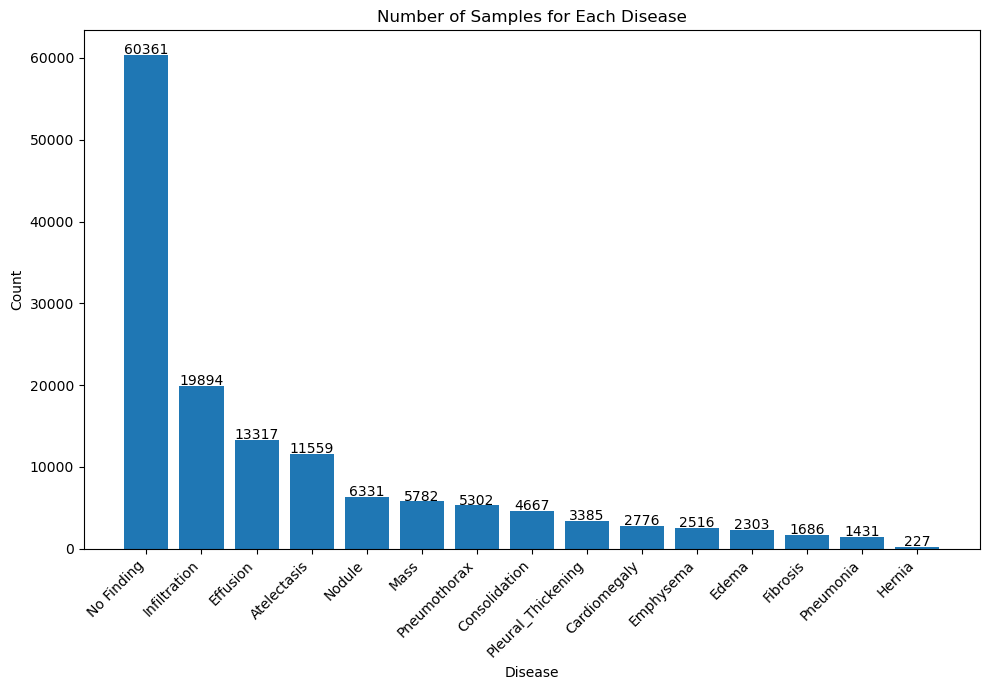

In [42]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
data = pd.read_csv(os.path.join(dataset_path, 'data_entry_chest_with_one_hot.csv'))

# Define the disease labels dictionary
# labels_dict = {"Atelectasis": 0, "Cardiomegaly": 1, "Consolidation": 2, "Edema": 3,
#                "Effusion": 4, "Emphysema": 5, "Fibrosis": 6, "Hernia": 7,
#                "Infiltration": 8, "Mass": 9, "No Finding": 10, "Nodule": 11,
#                "Pleural_Thickening": 12, "Pneumonia": 13, "Pneumothorax": 14}

# load the disease labels dictionary stored in json file
with open(os.path.join(dataset_path,'labels' , 'label_to_index.json'), 'r') as f:
    labels_dict = json.load(f)

# Create a dictionary to store the counts for each disease
disease_counts = {label: 0 for label in labels_dict.keys()}

# Count the occurrences of each disease using the One-Hot Encoded Labels column
for index, row in data.iterrows():
    one_hot_labels = eval(row['One-Hot Encoded Labels'])  # Convert string to list
    for disease, idx in labels_dict.items():
        disease_counts[disease] += one_hot_labels[idx]

# Sort disease counts in descending order for plotting
sorted_disease_counts = dict(sorted(disease_counts.items(), key=lambda item: item[1], reverse=True))

# Plot the data
plt.figure(figsize=(10, 7))
plt.bar(sorted_disease_counts.keys(), sorted_disease_counts.values())
plt.xticks(rotation=45, ha='right')
plt.xlabel('Disease')
plt.ylabel('Count')
plt.title('Number of Samples for Each Disease')

# Display counts on top of the bars
for i, (disease, count) in enumerate(sorted_disease_counts.items()):
    plt.text(i, count + 100, str(count), ha='center')

plt.tight_layout()
plt.show()


# Loading Arrays

In [43]:
# Define the paths where your arrays are saved

#Training array path
# image_array_path1 = '/content/drive/MyDrive/X-Ray Imaging/dataset/images/train/image_array_train.npy'
image_array_train_path = os.path.join(dataset_path, 'images', 'train', 'image_array_train.npy')
image_array_train_path_processed = os.path.join(dataset_path, 'images', 'train', 'processed_resnetv2_image_array_train.npy')
# label_array_path1 = '/content/drive/MyDrive/X-Ray Imaging/dataset/labels/train/label_array_train.npy'
label_array_train_path = os.path.join(dataset_path, 'labels', 'train', 'label_array_train.npy')

#Validation array path
# image_array_path2 = '/content/drive/MyDrive/X-Ray Imaging/dataset/images/val/image_array_val.npy'
image_array_val_path = os.path.join(dataset_path, 'images', 'val', 'image_array_val.npy')
image_array_val_path_processed = os.path.join(dataset_path, 'images', 'val', 'processed_resnetv2_image_array_val.npy')
# label_array_path2 = '/content/drive/MyDrive/X-Ray Imaging/dataset/labels/val/label_array_val.npy'
label_array_val_path = os.path.join(dataset_path, 'labels', 'val', 'label_array_val.npy')

In [44]:
import numpy as np

#Loading train data
image_array_train = np.load(image_array_train_path_processed, mmap_mode='r')
label_array_train = np.load(label_array_train_path, mmap_mode='r')

#Loading val data
image_array_val = np.load(image_array_val_path_processed, mmap_mode='r')
label_array_val = np.load(label_array_val_path, mmap_mode='r')

In [45]:
# print shapes with message
print("image_array_train shape:", image_array_train.shape)
print("label_array_train shape:", label_array_train.shape)

print("image_array_val shape:", image_array_val.shape)
print("label_array_val shape:", label_array_val.shape)


image_array_train shape: (70517, 224, 224, 3)
label_array_train shape: (70517, 14)
image_array_val shape: (16007, 224, 224, 3)
label_array_val shape: (16007, 14)


# Processing Image

In [46]:
# import numpy as np

# # Paths for saving the processed arrays
# processed_image_array_train_path = os.path.join(dataset_path, 'images', 'train', 'processed_densenet_image_array_train.npy')
# processed_image_array_val_path = os.path.join(dataset_path, 'images', 'val', 'processed_densenet_image_array_val.npy')


# # Process the image arrays
# image_array_train_processed = tf.keras.applications.densenet.preprocess_input(image_array_train)
# image_array_val_processed = tf.keras.applications.densenet.preprocess_input(image_array_val)

# # Save the processed arrays
# np.save(processed_image_array_train_path, image_array_train_processed)
# np.save(processed_image_array_val_path, image_array_val_processed)

# # Verify and print the saved shapes
# print("Processed image_array_train shape:", image_array_train_processed.shape)
# print("Processed image_array_val shape:", image_array_val_processed.shape)
# print(f"Processed training images saved to {processed_image_array_train_path}")
# print(f"Processed validation images saved to {processed_image_array_val_path}")


## Calculating Class Weights

In [47]:
import numpy as np

# Total number of samples
total_samples = label_array_train.shape[0]

# Count positive and negative samples for each class
positive_counts = np.sum(label_array_train, axis=0)
negative_counts = total_samples - positive_counts

# Calculate positive and negative weights for all classes
positive_weights = total_samples / (2 * positive_counts)
negative_weights = total_samples / (2 * negative_counts)

# Convert to dictionaries for consistency with the original format
positive_weights_dict = {c: positive_weights[c] for c in range(14)}
negative_weights_dict = {c: negative_weights[c] for c in range(14)}

print("Positive Weights:", positive_weights_dict)
print("Negative Weights:", negative_weights_dict)


Positive Weights: {0: np.float64(5.0090211677795144), 1: np.float64(25.095017793594305), 2: np.float64(16.240672501151543), 3: np.float64(30.500432525951556), 4: np.float64(4.7782219812982785), 5: np.float64(29.754008438818566), 6: np.float64(33.452087286527515), 7: np.float64(273.3217054263566), 8: np.float64(2.8921745549995896), 9: np.float64(10.83876421764525), 10: np.float64(9.14143116411719), 11: np.float64(19.57717934480844), 12: np.float64(47.905570652173914), 13: np.float64(16.60786622703721)}
Negative Weights: {0: np.float64(0.5554444059359148), 1: np.float64(0.5101646602616043), 2: np.float64(0.5158824217949843), 3: np.float64(0.5083332131889678), 4: np.float64(0.5584354905128449), 5: np.float64(0.5085458374199504), 6: np.float64(0.507586772814304), 7: np.float64(0.5009163493777349), 8: np.float64(0.6045074237904193), 9: np.float64(0.5241808396764985), 10: np.float64(0.5289303930393039), 11: np.float64(0.5131046626695384), 12: np.float64(0.5052736418222725), 13: np.float64(0.

# Creating data generator

In [48]:
#code that correctly works with shuffle

import numpy as np
from tensorflow.keras.utils import Sequence

class MemMappedDataGenerator(Sequence):
    def __init__(self, image_paths, label_array, batch_size, train=True, seed=None):
        super().__init__()

        self.image_paths = image_paths
        self.label_array = label_array
        self.batch_size = batch_size
        self.train = train
        self.seed = seed
        self.rng = np.random.default_rng(seed)  # Random generator for reproducibility
        self.indices = np.arange(len(self.image_paths))

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_x = [self.image_paths[i] for i in batch_indices]
        batch_y = [self.label_array[i] for i in batch_indices]
        return np.array(batch_x), np.array(batch_y)

    def on_epoch_end(self):
        if self.train:
            self.rng.shuffle(self.indices)  # Shuffle using the random generator

# Create generators using the memory-mapped arrays
train_gen = MemMappedDataGenerator(image_array_train, label_array_train, batch_size=32, train=True, seed=seed)
val_gen = MemMappedDataGenerator(image_array_val, label_array_val, batch_size=16, train=False)

# Model training

In [49]:
# settings seeds
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [50]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import DenseNet121

In [51]:

isLoaded = False

try:
    model = load_model(model_save_path)
    print("Loaded existing model.")
    isLoaded = True
except:
    print("No existing model found. Continuing with model creation.")
    
    
    if model_archi == MODEL_ARCHI.ResNet101V2:
      # Load the pre-trained ResNet101V2 model
      base_model = ResNet101V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif model_archi == MODEL_ARCHI.MobileNet:
        # Load the pre-trained MobileNet model
        base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif model_archi == MODEL_ARCHI.Xception:
        base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif model_archi == MODEL_ARCHI.ResNet50V2:
        base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif model_archi == MODEL_ARCHI.DenseNet121:
        base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    

    # Freeze the layers of the base model
    base_model.trainable = False
    # base_model.trainable = True
    # for layer in base_model.layers[:-30]:  # Freeze earlier layers and unfreeze top layers
    #     layer.trainable = False
    # for layer in base_model.layers:
    #   layer.trainable = True
    
    # Add custom layers for multi-label classification
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # x = Dropout(0.2)(x)
    x = Dense(512, activation='relu')(x)
    predictions = Dense(14, activation='sigmoid')(x)  # 15 classes for multi-label classification
    
    # Create the final model
    model = Model(inputs=base_model.input, outputs=predictions)

Loaded existing model.


In [52]:
import tensorflow.keras.backend as K
import tensorflow as tf

@tf.keras.utils.register_keras_serializable()
def loss_fn(y_true, y_pred):
    epsilon = K.epsilon()  # A small constant to avoid log(0)
    
    # # Use simple binary cross entropy for validation (when training is False)
    # if not training:
    #     print("not trianing")
    #     return tf.keras.losses.binary_crossentropy(y_true, y_pred)
    
    # Otherwise, use weighted loss for training
    loss = 0
    for c in range(label_array_train.shape[1]):  # Loop over all 14 or 15 classes
        y_pred_c = K.clip(y_pred[:, c], epsilon, 1 - epsilon)  # Clip predictions to avoid 0 or 1
        loss -= (
            positive_weights[c] * y_true[:, c] * K.log(y_pred_c) + 
            negative_weights[c] * (1 - y_true[:, c]) * K.log(1 - y_pred_c)
        )
    return K.mean(loss)  # Return the mean loss across the batch


In [53]:
# Compile the model
# model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy' , metrics=['accuracy','AUC'])
model.compile(optimizer=Adam(learning_rate=0.005), loss=loss_fn , metrics=['accuracy','AUC'])

# Model summary
# model.summary()

if isLoaded:
    print("Loaded existing model.")
else:
    print("No existing model found. Created new model.")

Loaded existing model.


In [54]:
# # Model Checkpoint to save the best model
# model_checkpoint = ModelCheckpoint(
#     model_save_path,
#     save_best_only=True,
#     monitor='val_loss',
#     mode='min',
#     verbose=1
# )

In [55]:
import os
import json
from tensorflow.keras.callbacks import Callback

class SaveBestAndAllModelsCallback(Callback):
    def __init__(self, save_dir, monitor='val_loss', mode='min'):
        """
        :param save_dir: Directory where models and history will be saved
        :param monitor: Metric to monitor (default: 'val_loss')
        :param mode: Mode for comparison ('min' or 'max' depending on the metric)
        """
        super(SaveBestAndAllModelsCallback, self).__init__()
        self.save_dir = save_dir
        os.makedirs(self.save_dir, exist_ok=True)
        self.monitor = monitor
        self.mode = mode
        self.best_value = float('inf') if mode == 'min' else -float('inf')
        self.best_epoch = None

        # Initialize lists to store history of models and metrics
        self.all_models_history = []
        self.best_models_history = []


        # Load previous histories if they exist
        self.load_existing_histories()
        # Automatically load the best epoch if it exists
        self.load_best_epoch_from_history()

        self.start_epoch = len(self.all_models_history)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}

        # Save the model for the current epoch (this will overwrite the previous epoch model)
        all_model_path = model_save_path
        self.model.save(all_model_path)
        print(f"Model saved for epoch {epoch+1}: {all_model_path}")

        # Store training history for all models
        self.all_models_history.append({
            'epoch': self.start_epoch + epoch + 1,
            'train_loss': logs.get('loss'),
            'val_loss': logs.get('val_loss'),
            'train_accuracy': logs.get('accuracy'),
            'val_accuracy': logs.get('val_accuracy'),
            'AUC': logs.get('AUC')
        })

        # Check if the current epoch gives the best result for the monitored metric
        current_value = logs.get(self.monitor)
        if current_value is not None:
            is_improvement = (current_value < self.best_value) if self.mode == 'min' else (current_value > self.best_value)
            if is_improvement:
                self.best_value = current_value
                self.best_epoch = epoch + 1

                # Save the best model (this will overwrite the previous best model)
                best_model_path = os.path.join(self.save_dir, "best_model.keras")
                self.model.save(best_model_path)
                print(f"Best model updated at epoch {self.best_epoch}: {best_model_path}")

                # Store the training history for the best model
                self.best_models_history.append({
                    'epoch': epoch + 1,
                    'train_loss': logs.get('loss'),
                    'val_loss': logs.get('val_loss'),
                    'train_accuracy': logs.get('accuracy'),
                    'val_accuracy': logs.get('val_accuracy'),
                    'AUC': logs.get('AUC')
                })

        # Save the training history for all models to a JSON file
        all_models_history_path = os.path.join(self.save_dir, "all_models_history.json")
        with open(all_models_history_path, "w") as f:
            json.dump(self.all_models_history, f, indent=4)

        # Save the training history for the best model to a JSON file
        best_models_history_path = os.path.join(self.save_dir, "best_models_history.json")
        if self.best_epoch == epoch + 1:
            with open(best_models_history_path, "w") as f:
                json.dump(self.best_models_history, f, indent=4)

    def load_existing_histories(self):
        """
        Loads existing histories from JSON files if they exist.
        """
        all_models_history_path = os.path.join(self.save_dir, "all_models_history.json")
        best_models_history_path = os.path.join(self.save_dir, "best_models_history.json")

        if os.path.exists(all_models_history_path):
            with open(all_models_history_path, "r") as f:
                self.all_models_history = json.load(f)
                print(f"Loaded existing all models history with {len(self.all_models_history)} entries.")

        if os.path.exists(best_models_history_path):
            with open(best_models_history_path, "r") as f:
                self.best_models_history = json.load(f)
                print(f"Loaded existing best models history with {len(self.best_models_history)} entries.")

    def load_best_epoch_from_history(self):
        """
        Automatically loads the best epoch number from the saved history file, if it exists.
        """
        best_models_history_path = os.path.join(self.save_dir, "best_models_history.json")
        if os.path.exists(best_models_history_path):
            with open(best_models_history_path, 'r') as f:
                best_models_history = json.load(f)
                if best_models_history:
                    self.best_epoch = best_models_history[-1]['epoch']  # Get the best epoch from the last entry
                    print(f"Loaded best epoch from history: Epoch {self.best_epoch}")
                else:
                    print("No best epoch found in history, starting fresh.")
        else:
            print("No history found, starting fresh.")

    def get_best_epoch(self):
        """
        Function to retrieve the best epoch number (based on the saved history)
        """
        return self.best_epoch

# Example usage:
# Callback instance (best_epoch is automatically loaded at the start of training)
save_best_and_all_models = SaveBestAndAllModelsCallback(save_dir=model_folder_path, monitor='val_loss', mode='min')


Loaded existing all models history with 100 entries.
Loaded existing best models history with 4 entries.
Loaded best epoch from history: Epoch 10


In [56]:
# prompt: load last all_saved model epoch number from "all_models_history.json")

def load_last_saved_epoch(model_folder_path):
  """Loads the last saved epoch number from the 'all_models_history.json' file."""
  all_models_history_path = os.path.join(model_folder_path, "all_models_history.json")
  if os.path.exists(all_models_history_path):
    with open(all_models_history_path, 'r') as f:
      all_models_history = json.load(f)
      if all_models_history:
        last_saved_epoch = all_models_history[-1]['epoch']
        return last_saved_epoch
      else:
        print("No epochs found in all_models_history.json")
        return 0
  else:
    print("all_models_history.json not found.")
    return 0


last_saved_epoch = load_last_saved_epoch(model_folder_path)
if last_saved_epoch:
  print(f"Last saved epoch: {last_saved_epoch}")
else:
  print(f"No last saved epoch found. Starting with epoch {last_saved_epoch}")

Last saved epoch: 100


In [57]:
# Define the learning rate schedule function
def get_learning_rate_scheduler(start_epoch):
  def lr_schedule(epoch):
      absolute_epoch = start_epoch + epoch
      if absolute_epoch < 60:
          return 0.0005
      elif 60 <= absolute_epoch < 80:
          return 0.00005
      elif 80 <= absolute_epoch < 90:
          return 0.00003
      else:
          return 0.00001

  return LearningRateScheduler(lr_schedule, verbose=1)

lr_scheduler = get_learning_rate_scheduler(last_saved_epoch)

In [58]:
from tensorflow.keras.callbacks import TensorBoard

# Set up the log directory for TensorBoard
log_dir = os.path.join("tensorboard-logs", "fit","jamshaid", model_archi_name, f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')} Start epoch : {last_saved_epoch}" )
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
# Create a ReduceLROnPlateau callback
lr_plateau_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',  # The metric to monitor (e.g., 'val_loss' or 'val_accuracy')
    factor=0.5,          # Factor by which the learning rate will be reduced
    patience=2,          # Number of epochs with no improvement before reducing the learning rate
    min_lr=1e-6,         # Minimum learning rate
    verbose=1            # Print when the learning rate is reduced
)

In [224]:
from tensorflow.keras.models import save_model
import matplotlib.pyplot as plt

# Train the model using the dataset
# history = model.fit(train_gen, epochs=100, validation_data=val_gen, callbacks=[model_checkpoint, lr_scheduler])
# history = model.fit(train_gen, epochs=100,  callbacks=[model_checkpoint, lr_scheduler])
# history = model.fit(train_gen, epochs=100-last_saved_epoch, validation_data=val_gen, callbacks=[save_best_and_all_models, lr_scheduler, tensorboard_callback])
history = model.fit(train_gen, epochs=100-last_saved_epoch, validation_data=val_gen, callbacks=[save_best_and_all_models, lr_plateau_callback, tensorboard_callback])


2204/2204 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - AUC: 0.5000 - accuracy: 0.0107 - loss: 9.7080Model saved for epoch 24: /home/chestxray/Desktop/X-Ray Imaging/models/DenseNet121/DenseNet121.keras
2204/2204 ━━━━━━━━━━━━━━━━━━━━ 200s 91ms/step - AUC: 0.5000 - accuracy: 0.0107 - loss: 9.7080 - val_AUC: 0.5000 - val_accuracy: 0.0119 - val_loss: 9.2034 - learning_rate: 4.8828e-06
Epoch 25/100
2204/2204 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - AUC: 0.5000 - accuracy: 0.0101 - loss: 9.6964Model saved for epoch 25: /home/chestxray/Desktop/X-Ray Imaging/models/DenseNet121/DenseNet121.keras

Epoch 25: ReduceLROnPlateau reducing learning rate to 2.441406195430318e-06.
2204/2204 ━━━━━━━━━━━━━━━━━━━━ 200s 91ms/step - AUC: 0.5000 - accuracy: 0.0101 - loss: 9.6964 - val_AUC: 0.5000 - val_accuracy: 0.0119 - val_loss: 9.2034 - learning_rate: 4.8828e-06
Epoch 26/100
2204/2204 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - AUC: 0.5000 - accuracy: 0.0115 - loss: 9.6609Model saved for epoch 26: /home/chestxray/Desktop/X-Ray I

KeyboardInterrupt: 

## Plotting last saved model

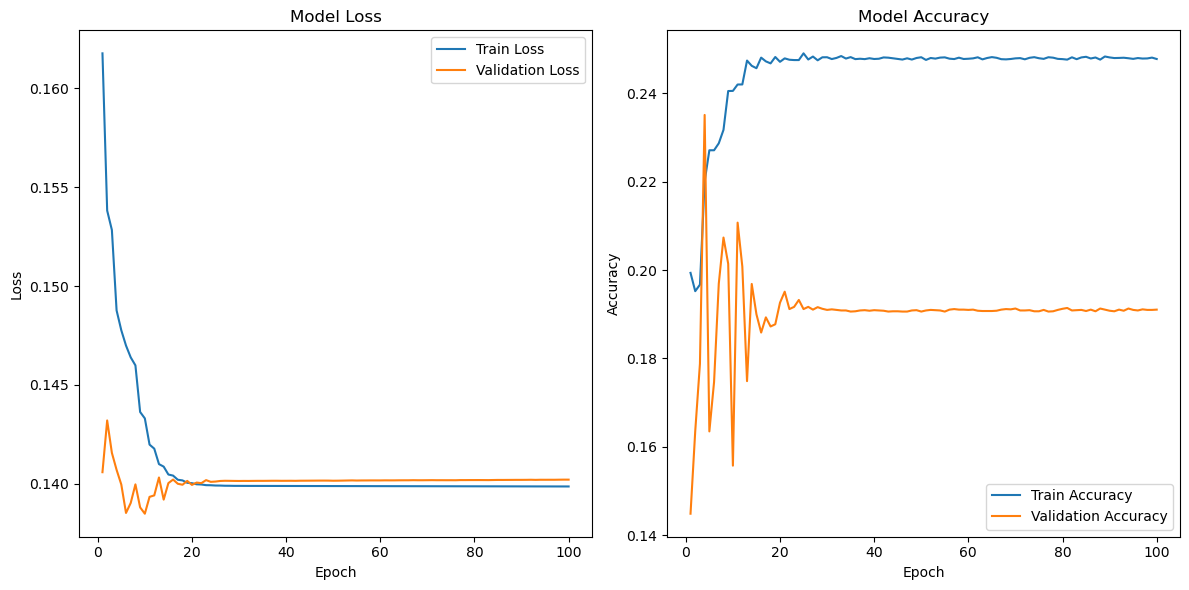

In [59]:
 # prompt: plot loss and accuracy graph of all_models_history.json

import json
import matplotlib.pyplot as plt

# Load the training history from the JSON file
with open(f'{model_folder_path}/all_models_history.json', 'r') as f:
    history = json.load(f)

# Extract loss and accuracy values
train_loss = [entry['train_loss'] for entry in history]
val_loss = [entry['val_loss'] for entry in history]
train_accuracy = [entry['train_accuracy'] for entry in history]
val_accuracy = [entry['val_accuracy'] for entry in history]
epochs = [entry['epoch'] for entry in history]


# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, label='Train Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Plotting best saved model

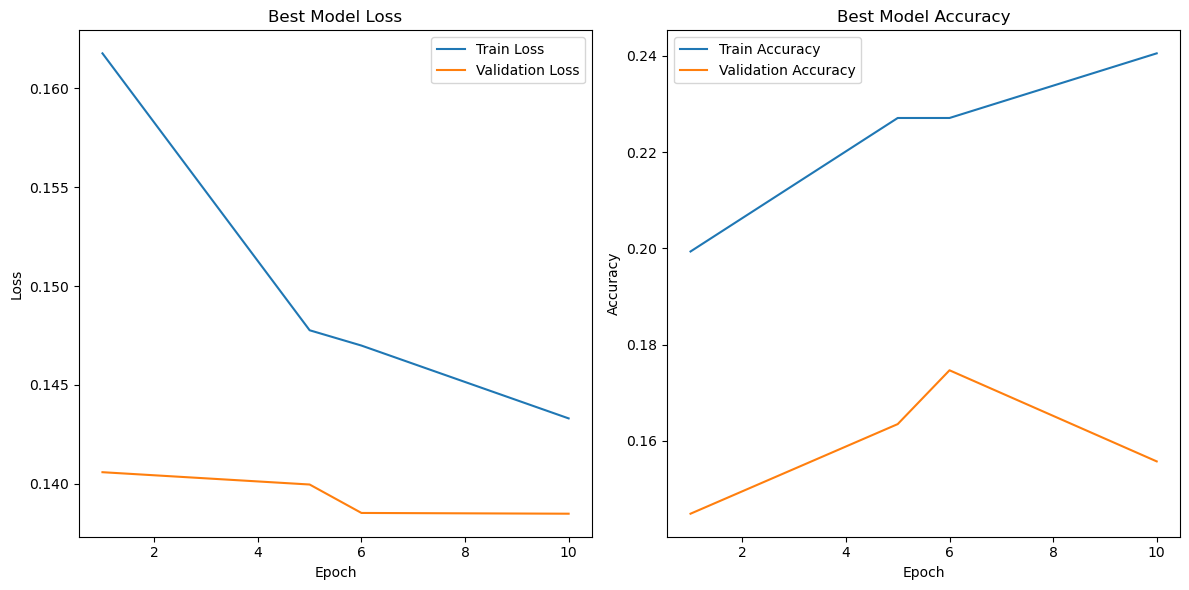

In [60]:
# prompt: similary plot best_saved model accraucy and loss by loading from json file

# Load the training history from the JSON file
with open(f'{model_folder_path}/best_models_history.json', 'r') as f:
    best_history = json.load(f)

# Extract loss and accuracy values
best_train_loss = [entry['train_loss'] for entry in best_history]
best_val_loss = [entry['val_loss'] for entry in best_history]
best_train_accuracy = [entry['train_accuracy'] for entry in best_history]
best_val_accuracy = [entry['val_accuracy'] for entry in best_history]
best_epochs = [entry['epoch'] for entry in best_history]


# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(best_epochs, best_train_loss, label='Train Loss')
plt.plot(best_epochs, best_val_loss, label='Validation Loss')
plt.title('Best Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(best_epochs, best_train_accuracy, label='Train Accuracy')
plt.plot(best_epochs, best_val_accuracy, label='Validation Accuracy')
plt.title('Best Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### model predictions

In [61]:
## loads best saved model
model = load_model(model_save_path)

In [103]:
# prompt: get y_pred using val_gen

y_pred = model.predict(val_gen)

1001/1001 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step


In [104]:
y_true = label_array_val

In [105]:
# from sklearn.metrics import roc_auc_score, recall_score, confusion_matrix, accuracy_score
# import numpy as np
# import pandas as pd

# # Assuming y_true contains the one-hot encoded true labels (shape: [n_samples, n_classes])
# # and y_pred contains the sigmoid outputs (shape: [n_samples, n_classes])

# # Threshold the sigmoid outputs to obtain binary predictions
# y_pred_binary = (y_pred >= 0.5).astype(int)
# # y_pred_binary= (y_pred >= optimal_thresholds).astype(int)

# # # Define the label mapping
# # label_mapping = {
# #     0: "Atelectasis",
# #     1: "Cardiomegaly",
# #     2: "Consolidation",
# #     3: "Edema",
# #     4: "Effusion",
# #     5: "Emphysema",
# #     6: "Fibrosis",
# #     7: "Hernia",
# #     8: "Infiltration",
# #     9: "Mass",
# #     10: "No Finding",  # This will be ignored in the final report
# #     11: "Nodule",
# #     12: "Pleural_Thickening",
# #     13: "Pneumonia",
# #     14: "Pneumothorax"
# # }

# # loads label mapping stored in json file
# with open(os.path.join(dataset_path,'labels' , 'index_to_label.json'), 'r') as f:
#     label_mapping = json.load(f)

# label_mapping = {int(k): v for k, v in label_mapping.items()}

# # Overall Accuracy (average accuracy per sample)
# sample_accuracy = round(accuracy_score(y_true, y_pred_binary, normalize=True) * 100, 3)

# # AUC per class (one-vs-rest for each class)
# auc_scores = roc_auc_score(y_true, y_pred, average=None)

# # Initialize lists to store per-class metrics
# accuracies = []
# recalls = []
# tnrs = []
# fprs = []
# fnrs = []

# # Calculate per-class metrics
# for i in range(y_true.shape[1]):
#     # Skip "No Finding" class (index 10)
#     if i == 10:
#         continue

#     # True Positives, False Positives, True Negatives, False Negatives
#     tn, fp, fn, tp = confusion_matrix(y_true[:, i], y_pred_binary[:, i]).ravel()

#     # Accuracy for the current class
#     accuracy = round((tp + tn) / (tp + tn + fp + fn) * 100, 3)
#     accuracies.append(accuracy)

#     # Recall (Sensitivity/TPR) for the current class
#     recall = round(tp / (tp + fn) * 100, 3) if (tp + fn) != 0 else 0.0
#     recalls.append(recall)

#     # True Negative Rate (TNR) or Specificity
#     tnr = round(tn / (tn + fp) *100, 3) if (tn + fp) != 0 else 0.0
#     tnrs.append(tnr)

#     # False Positive Rate (FPR)
#     fpr = round(fp / (fp + tn) * 100, 3) if (fp + tn) != 0 else 0.0
#     fprs.append(fpr)

#     # False Negative Rate (FNR)
#     fnr = round(fn / (fn + tp) * 100, 3) if (fn + tp) != 0 else 0.0
#     fnrs.append(fnr)

# # Exclude AUC for "No Finding" and get disease names for classes other than "No Finding"
# auc_scores_filtered = [round(auc_scores[i]* 100, 3) for i in range(y_true.shape[1]) if i != 10]
# classes_filtered = [label_mapping[i] for i in range(y_true.shape[1]) if i != 10]

# # Combine all metrics into a DataFrame for easier display
# report_df = pd.DataFrame({
#     'Class': classes_filtered,
#     'Accuracy': accuracies,
#     'AUC': auc_scores_filtered,
#     'Recall': recalls,
#     'TNR': tnrs,
#     'FPR': fprs,
#     'FNR': fnrs
# })

# # Calculate averages for each metric
# average_metrics = {
#     'Class': 'Average',
#     'Accuracy': round(np.mean(accuracies), 3),
#     'AUC': round(np.mean(auc_scores_filtered), 3),
#     'Recall': round(np.mean(recalls), 3),
#     'TNR': round(np.mean(tnrs), 3),
#     'FPR': round(np.mean(fprs), 3),
#     'FNR': round(np.mean(fnrs), 3)
# }

# # Append the average row to the DataFrame
# report_df = pd.concat([report_df, pd.DataFrame([average_metrics])], ignore_index=True)

# print("Sample-wise Accuracy:", sample_accuracy)
# print(report_df)


In [106]:
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix
import numpy as np
import pandas as pd
import os
import json

# Assuming y_true contains the one-hot encoded true labels (shape: [n_samples, n_classes])
# and y_pred contains the sigmoid outputs (shape: [n_samples, n_classes])

# Load label mapping stored in JSON file
with open(os.path.join(dataset_path, 'labels', 'index_to_label.json'), 'r') as f:
    label_mapping = json.load(f)
label_mapping = {int(k): v for k, v in label_mapping.items()}

# Initialize variables
optimal_thresholds = []
auc_scores = roc_auc_score(y_true, y_pred, average=None)

# Find optimal thresholds for each class
for i in range(y_true.shape[1]):
    if i == 10:  # Skip "No Finding" class (index 10)
        optimal_thresholds.append(0.5)  # Default threshold
        continue

    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(y_true[:, i], y_pred[:, i])

    # Compute Youden's Index
    youden_index = tpr - fpr
    optimal_idx = np.argmax(youden_index)
    optimal_thresholds.append(thresholds[optimal_idx])

# Convert predictions to binary using optimal thresholds
y_pred_binary = np.zeros_like(y_pred)
for i in range(y_pred.shape[1]):
    y_pred_binary[:, i] = (y_pred[:, i] >= optimal_thresholds[i]).astype(int)

# Overall Accuracy (average accuracy per sample)
sample_accuracy = round(accuracy_score(y_true, y_pred_binary, normalize=True) * 100, 3)

# Initialize lists to store per-class metrics
accuracies = []
recalls = []
tnrs = []
fprs = []
fnrs = []

# Calculate per-class metrics
for i in range(y_true.shape[1]):
    if i == 10:  # Skip "No Finding" class
        continue

    # True Positives, False Positives, True Negatives, False Negatives
    tn, fp, fn, tp = confusion_matrix(y_true[:, i], y_pred_binary[:, i]).ravel()

    # Accuracy for the current class
    accuracy = round((tp + tn) / (tp + tn + fp + fn) * 100, 3)
    accuracies.append(accuracy)

    # Recall (Sensitivity/TPR) for the current class
    recall = round(tp / (tp + fn) * 100, 3) if (tp + fn) != 0 else 0.0
    recalls.append(recall)

    # True Negative Rate (TNR) or Specificity
    tnr = round(tn / (tn + fp) * 100, 3) if (tn + fp) != 0 else 0.0
    tnrs.append(tnr)

    # False Positive Rate (FPR)
    fpr = round(fp / (fp + tn) * 100, 3) if (fp + tn) != 0 else 0.0
    fprs.append(fpr)

    # False Negative Rate (FNR)
    fnr = round(fn / (fn + tp) * 100, 3) if (fn + tp) != 0 else 0.0
    fnrs.append(fnr)

# Exclude AUC for "No Finding" and get disease names for classes other than "No Finding"
auc_scores_filtered = [round(auc_scores[i] * 100, 3) for i in range(y_true.shape[1]) if i != 10]
classes_filtered = [label_mapping[i] for i in range(y_true.shape[1]) if i != 10]

# Combine all metrics into a DataFrame for easier display
report_df = pd.DataFrame({
    'Class': classes_filtered,
    'Accuracy': accuracies,
    'AUC': auc_scores_filtered,
    'Recall': recalls,
    'TNR': tnrs,
    'FPR': fprs,
    'FNR': fnrs
})

# Calculate averages for each metric
average_metrics = {
    'Class': 'Average',
    'Accuracy': round(np.mean(accuracies), 3),
    'AUC': round(np.mean(auc_scores_filtered), 3),
    'Recall': round(np.mean(recalls), 3),
    'TNR': round(np.mean(tnrs), 3),
    'FPR': round(np.mean(fprs), 3),
    'FNR': round(np.mean(fnrs), 3)
}

# Append the average row to the DataFrame
report_df = pd.concat([report_df, pd.DataFrame([average_metrics])], ignore_index=True)

print("Sample-wise Accuracy:", sample_accuracy)
print("Optimal Thresholds:", optimal_thresholds)
print(report_df)


Sample-wise Accuracy: 13.244
Optimal Thresholds: [np.float32(0.09926087), np.float32(0.014122991), np.float32(0.03190087), np.float32(0.011778631), np.float32(0.099680886), np.float32(0.014782914), np.float32(0.015423611), np.float32(0.00041037414), np.float32(0.17722788), np.float32(0.04023301), 0.5, np.float32(0.030665256), np.float32(0.009817165), np.float32(0.027500935)]
                 Class  Accuracy     AUC   Recall     TNR     FPR     FNR
0          Atelectasis    66.458  75.578   74.778  65.759  34.241  25.222
1         Cardiomegaly    68.770  77.627   74.172  68.666  31.334  25.828
2        Consolidation    69.576  76.378   71.806  69.477  30.523  28.194
3                Edema    79.290  85.052   77.477  79.316  20.684  22.523
4             Effusion    73.936  81.207   74.375  73.898  26.102  25.625
5            Emphysema    73.318  73.051   60.504  73.511  26.489  39.496
6             Fibrosis    60.961  70.682   71.574  60.829  39.171  28.426
7               Hernia    58.4

In [107]:
report_df.to_csv(os.path.join(model_folder_path, f'{model_archi_name}_classification_report.csv'), index=False)

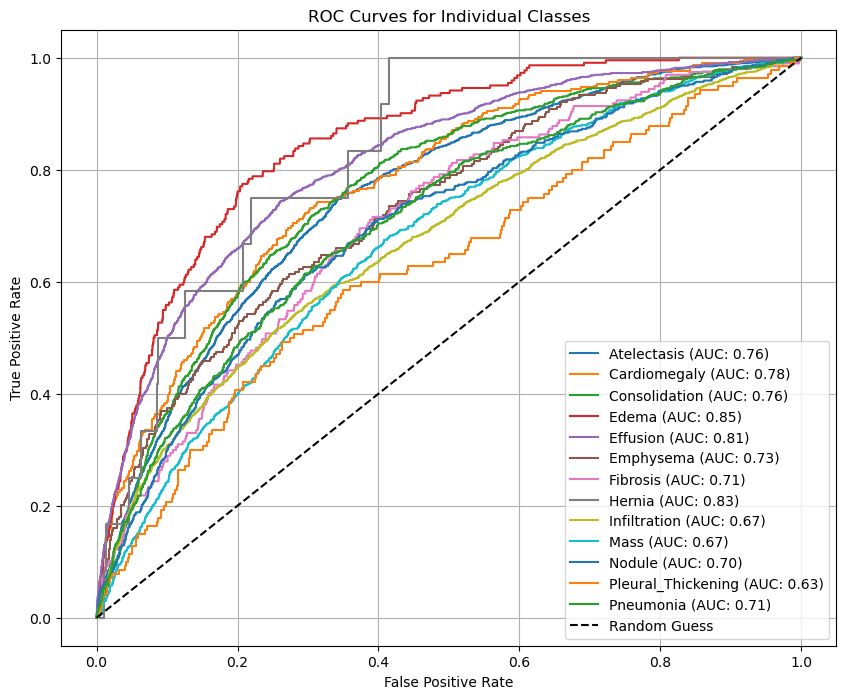

In [67]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# Plot ROC curves for individual classes
plt.figure(figsize=(10, 8))

for i in range(y_true.shape[1]):
    if i == 10:  # Skip "No Finding" class
        continue
    
    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
    
    # Plot the ROC curve
    plt.plot(fpr, tpr, label=f'{label_mapping[i]} (AUC: {auc_scores[i]:.2f})')

# Plot the diagonal line
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

# Add labels, legend, and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Individual Classes')
plt.legend(loc='lower right')
plt.grid()

# Save the figure
plt.savefig(f"{model_folder_path}/roc-curve.png")

plt.show()


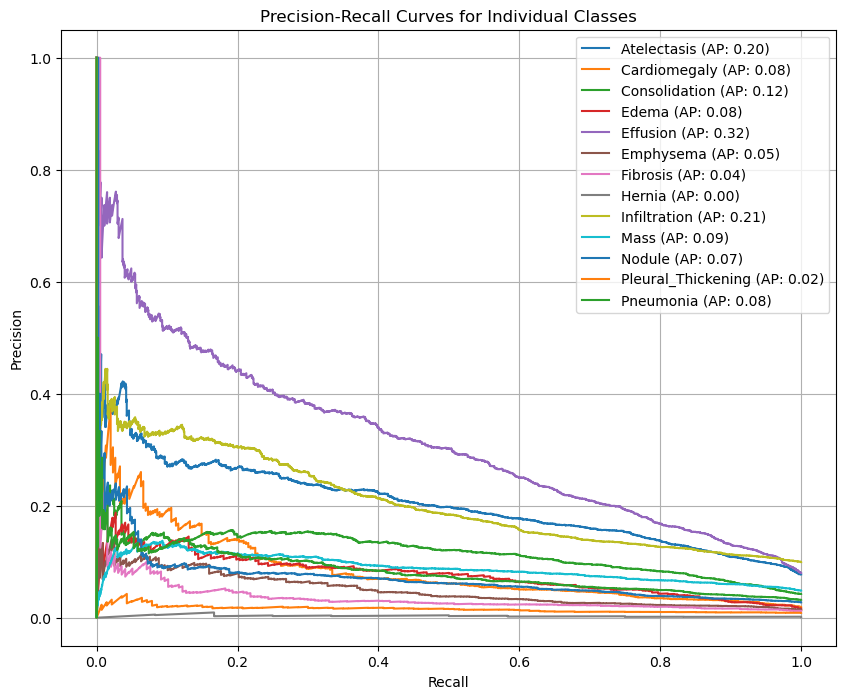

In [68]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Plot Precision-Recall curves for individual classes
plt.figure(figsize=(10, 8))

for i in range(y_true.shape[1]):
    if i == 10:  # Skip "No Finding" class
        continue
    
    # Compute Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_true[:, i], y_pred[:, i])
    avg_precision = average_precision_score(y_true[:, i], y_pred[:, i])
    
    # Plot the Precision-Recall curve
    plt.plot(recall, precision, label=f'{label_mapping[i]} (AP: {avg_precision:.2f})')

# Add labels, legend, and title
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for Individual Classes')
plt.legend(loc='upper right')
plt.grid()

# Save the figure
plt.savefig(f"{model_folder_path}/precision-recall.png")

# Optionally, show the plot
plt.show()


# GradCam

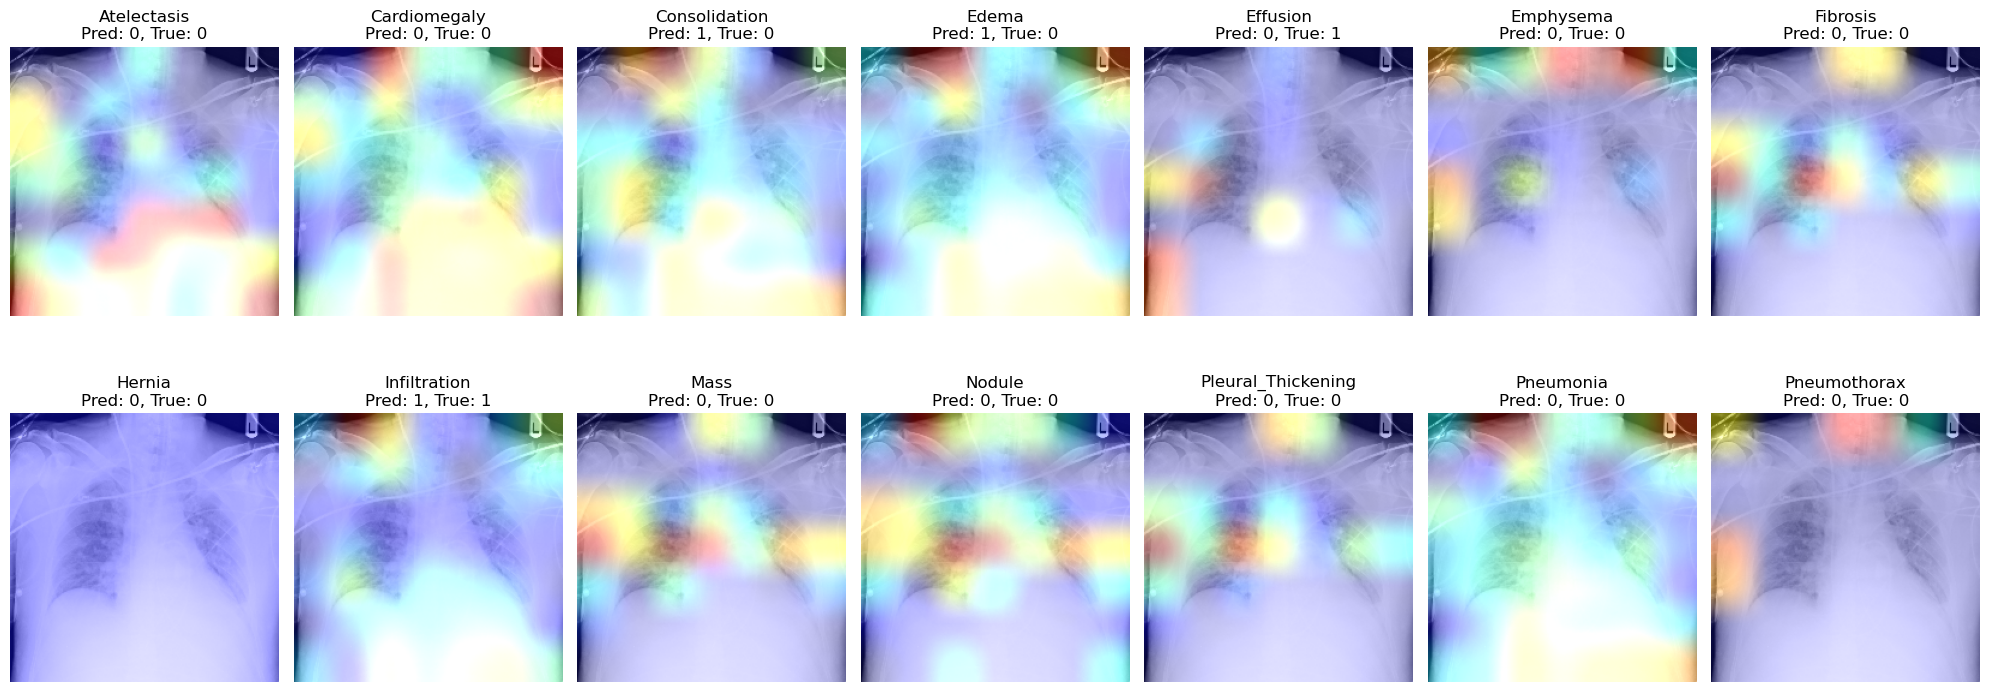

In [122]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.utils import array_to_img
from sklearn.metrics import roc_curve, roc_auc_score

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """
    Generate Grad-CAM heatmap for the given image and model.
    """
    grad_model = Model(
        inputs=model.input,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + tf.keras.backend.epsilon())
    return heatmap.numpy(), predictions.numpy()

def overlay_gradcam(original_img, heatmap, alpha=0.4):
    """
    Overlay the Grad-CAM heatmap on the original image.
    """
    heatmap = np.uint8(255 * heatmap)
    jet = plt.colormaps["jet"]
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((original_img.shape[1], original_img.shape[0]))
    jet_heatmap = np.array(jet_heatmap)
    superimposed_img = jet_heatmap * alpha + original_img
    superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)
    return superimposed_img

def plot_gradcam_subplots(img, true_labels, model, last_conv_layer_name, class_labels, optimal_thresholds):
    """
    Generate Grad-CAM overlays for all classes and display them as subplots.
    """
    fig, axes = plt.subplots(2, 7, figsize=(20, 8))  # Adjust rows/columns based on 14 classes
    axes = axes.flatten()
    
    original_img = img.copy()
    preprocessed_img = np.expand_dims(tf.keras.applications.densenet.preprocess_input(original_img), axis=0)

    for i, ax in enumerate(axes):
        heatmap, predictions = make_gradcam_heatmap(preprocessed_img, model, last_conv_layer_name, pred_index=i)
        overlay = overlay_gradcam(original_img, heatmap)
        raw_pred = predictions[0, i]
        pred_binary = int(raw_pred > optimal_thresholds[i])  # Convert to binary prediction using optimal thresholds
        true_label = true_labels[i]

        ax.imshow(overlay)
        ax.set_title(f"{class_labels[i]}\nPred: {pred_binary}, True: {true_label}")
        ax.axis("off")
    
    plt.tight_layout()
    plt.show()

# Calculate optimal thresholds
def calculate_optimal_thresholds(y_true, y_pred):
    """
    Calculate optimal thresholds for each class using Youden's Index.
    """
    optimal_thresholds = []
    auc_scores = roc_auc_score(y_true, y_pred, average=None)

    for i in range(y_true.shape[1]):
        if i == 10:  # Skip "No Finding" class (index 10)
            optimal_thresholds.append(0.5)  # Default threshold
            continue

        # Compute ROC curve
        fpr, tpr, thresholds = roc_curve(y_true[:, i], y_pred[:, i])

        # Compute Youden's Index
        youden_index = tpr - fpr
        optimal_idx = np.argmax(youden_index)
        optimal_thresholds.append(thresholds[optimal_idx])
    
    return optimal_thresholds

# Example usage
last_conv_layer_name = "conv5_block3_out" 
class_labels = [
    "Atelectasis", "Cardiomegaly", "Consolidation", "Edema", "Effusion",
    "Emphysema", "Fibrosis", "Hernia", "Infiltration", "Mass",
    "Nodule", "Pleural_Thickening", "Pneumonia", "Pneumothorax"
]

# Replace with your actual image, true labels, and predictions
index = 10030
image_array = np.load(image_array_val_path, mmap_mode='r')[index]
true_label_array = np.load(label_array_val_path, mmap_mode='r')[index]


# Plot Grad-CAM overlays for all 14 classes
plot_gradcam_subplots(image_array, true_label_array, model, last_conv_layer_name, class_labels, optimal_thresholds)


In [102]:
image_array = np.load(image_array_val_path, mmap_mode='r')
true_label_array = np.load(label_array_val_path, mmap_mode='r')
for i in range(0,image_array.shape[0]):
    if any(true_label_array[i]):  # Check if any value in the one-hot vector is 1
        print(f"{i} : {true_label_array[i]}")


10000 : [0 1 0 0 0 0 0 0 1 0 0 0 0 0]
10001 : [0 0 0 0 1 0 0 0 1 0 0 0 0 0]
10002 : [0 1 0 0 0 0 0 0 1 0 0 0 0 0]
10003 : [0 0 0 0 1 0 0 0 1 0 0 0 0 0]
10004 : [0 1 0 0 0 0 0 0 1 0 0 0 0 0]
10005 : [0 0 0 0 1 0 0 0 1 0 0 0 0 0]
10006 : [1 0 1 0 1 0 0 0 1 0 0 0 0 0]
10007 : [0 0 1 0 0 0 0 0 1 0 0 0 0 0]
10008 : [0 0 0 0 1 0 0 0 1 0 0 0 0 0]
10009 : [1 0 0 0 1 0 0 0 1 0 0 0 0 0]
10010 : [1 1 0 0 0 0 0 0 1 0 0 0 0 0]
10011 : [0 0 0 0 0 0 0 0 1 1 0 0 0 0]
10012 : [0 0 1 0 0 0 0 0 1 0 0 0 0 0]
10013 : [1 0 0 0 1 0 0 0 1 0 0 0 0 0]
10014 : [0 0 1 0 1 0 0 0 1 0 0 0 0 0]
10015 : [1 0 0 0 1 0 0 0 1 0 0 0 0 0]
10016 : [0 0 0 0 1 0 0 0 1 0 0 0 0 0]
10017 : [0 0 0 0 0 0 0 0 1 1 0 0 0 0]
10018 : [0 0 1 0 0 0 0 0 1 0 0 0 0 0]
10019 : [0 0 1 0 0 0 0 0 1 0 0 0 0 0]
10020 : [0 0 1 0 0 0 0 0 1 0 0 0 0 0]
10021 : [0 0 0 0 0 0 0 0 1 0 0 1 0 0]
10022 : [0 0 1 0 0 0 0 0 1 0 0 0 0 0]
10023 : [0 0 0 0 1 0 0 0 1 0 0 0 0 1]
10024 : [0 0 1 0 0 0 0 0 1 0 0 0 0 0]
10025 : [0 0 0 0 0 0 0 0 1 1 0 0 0 0]
10026 : [1 0